In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%pip install ultralytics
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/107.7 GB disk)


In [3]:
import albumentations as ant
from tqdm import tqdm
import os

In [4]:
import cv2
from sklearn.model_selection import train_test_split

In [5]:
SEED = 45
def reproduce_result(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

reproduce_result(SEED)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset_path = '/content/drive/MyDrive/dataset'
os.listdir(dataset_path)

['nightTrain',
 'sample-dayClip6',
 'sample-nightClip1',
 'daySequence2',
 'Annotations',
 'dayTrain',
 'daySequence1',
 'nightSequence1',
 'nightSequence2',
 '.ipynb_checkpoints',
 'images',
 'labels']

In [8]:
model = YOLO("yolov8n")
print(model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [8]:
dayTrain_path = '/content/drive/MyDrive/dataset/Annotations/Annotations/dayTrain/'
nightTrain_path = '/content/drive/MyDrive/dataset/Annotations/Annotations/nightTrain/'

In [9]:
train_day = []
for clipName in tqdm(sorted(os.listdir(dayTrain_path))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(dayTrain_path,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)

train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0

train_night = []
for clipName in tqdm(sorted(os.listdir(nightTrain_path))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(nightTrain_path,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)

100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


In [10]:
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [11]:
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [12]:
def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight

    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(dataset_path,f'nightTrain/nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(dataset_path,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [13]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'], dtype=object)

In [14]:
label_to_idx = {'go':0, 'warning':1, 'stop': 2}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']

df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([0, 2, 1])

In [15]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0


In [16]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

In [17]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0


In [18]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


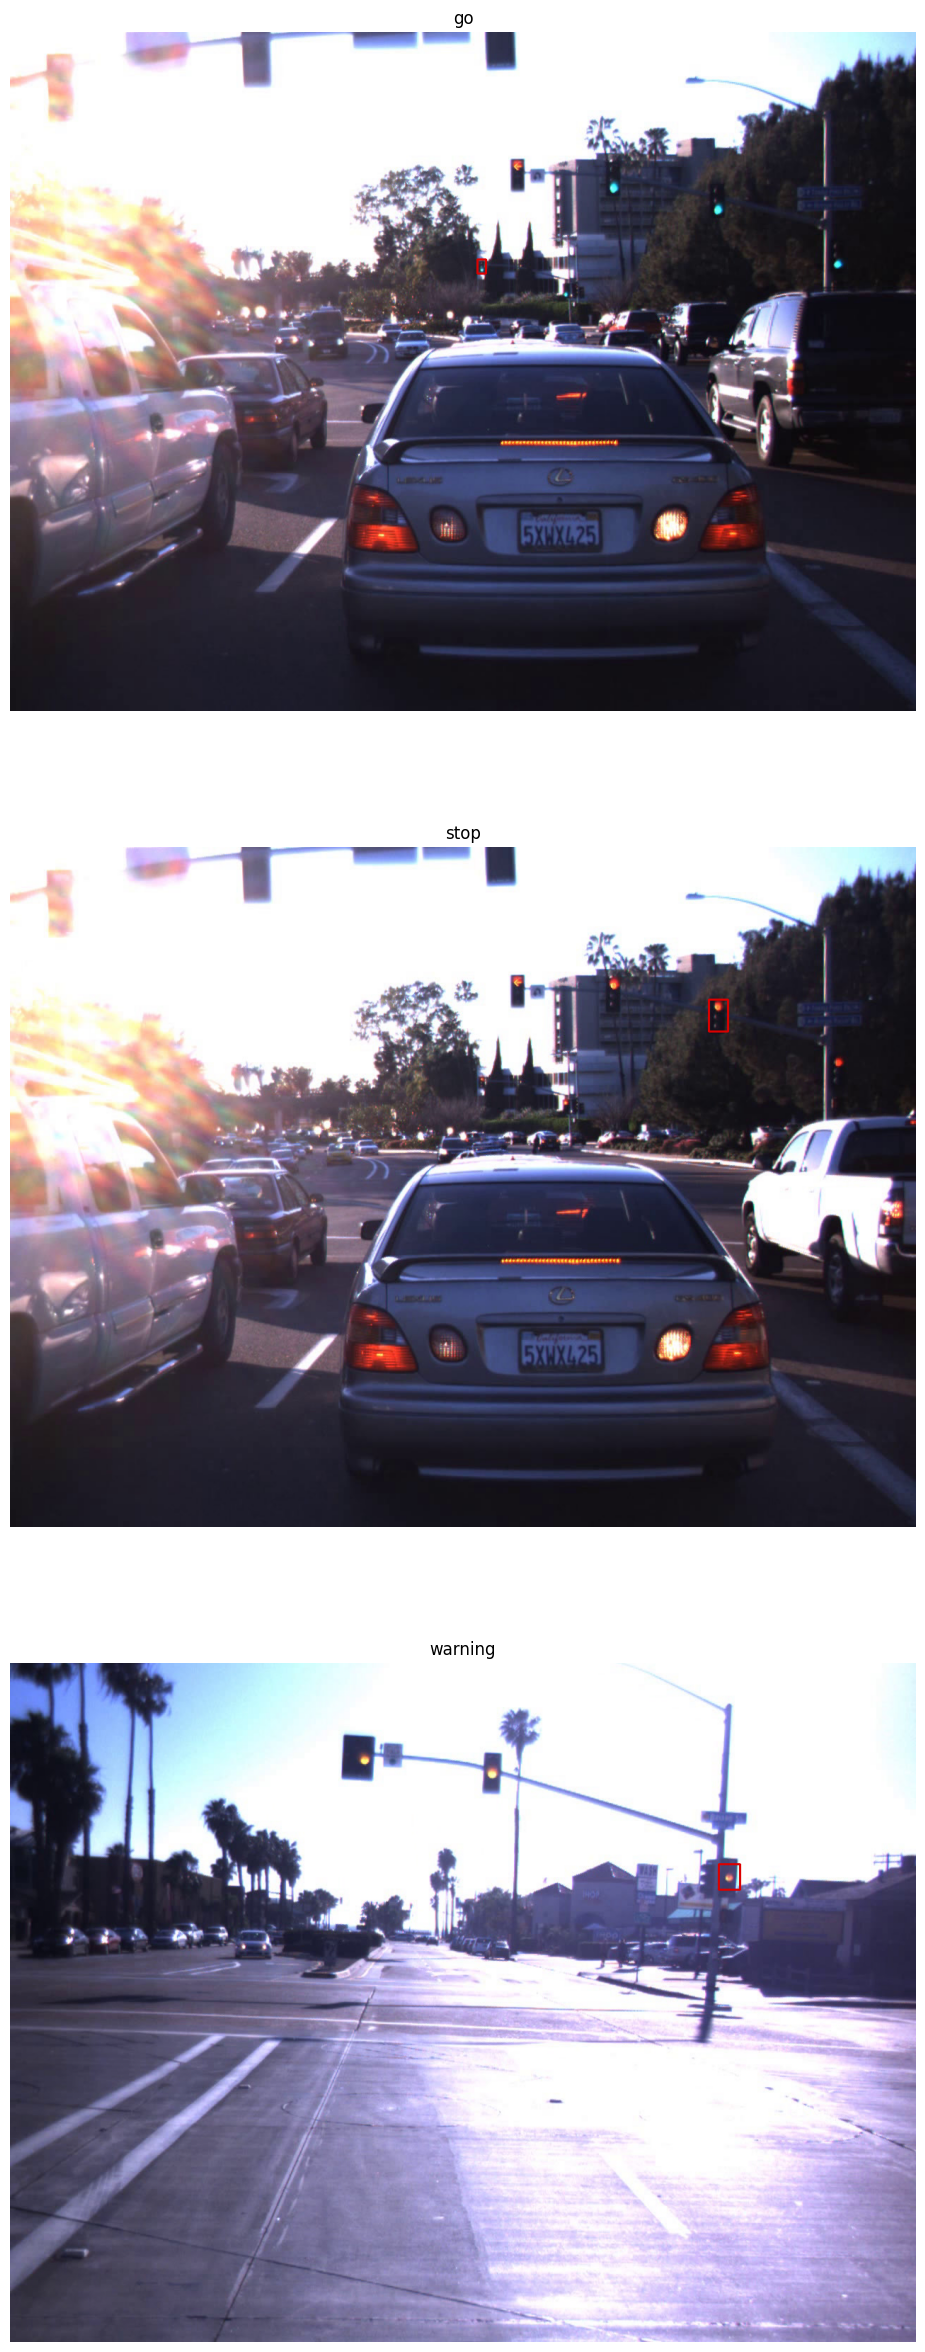

In [19]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]

    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)

    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [20]:
def extract_clip_name(image_path):
    parts = image_path.split('/')
    for part in parts:
        if 'Clip' in part:
            return part.split('--')[0]

df['clipNames'] = df['image_id'].apply(extract_clip_name)
print(df['clipNames'].unique())

['dayClip1' 'dayClip10' 'dayClip11' 'dayClip12' 'dayClip13' 'dayClip2' 'dayClip3' 'dayClip4' 'dayClip5' 'dayClip6' 'dayClip7' 'dayClip8' 'dayClip9' 'nightClip1' 'nightClip2' 'nightClip3' 'nightClip4' 'nightClip5']


In [21]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*p)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames

    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]

    return train_df, test_df

In [22]:
train_df, test_df = split(df)

In [23]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0,dayClip1
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0,dayClip1
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0,dayClip1
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0,dayClip1
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0,dayClip1


In [25]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,271,379,283,399,0,0,dayClip12
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,610,294,625,314,0,0,dayClip12
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,774,359,792,394,0,0,dayClip12
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,266,364,284,404,1,0,dayClip12
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,609,293,627,313,1,0,dayClip12


In [24]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (44697, 9)
Test shape:  (7129, 9)


In [25]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0,dayClip1
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0,dayClip1
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0,dayClip1
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0,dayClip1
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0,dayClip1


In [26]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,902,242,929,287,0,0,dayClip2
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,1220,334,1244,374,0,0,dayClip2
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,754,243,784,288,0,0,dayClip2
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,174,351,192,378,0,0,dayClip2
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,902,240,929,289,1,0,dayClip2


In [27]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (37348, 9)
Validation shape:  (7349, 9)


In [28]:
image_width = 1280
image_height = 960

In [29]:
val_df['x_center'] = ((val_df['x_min'] + val_df['x_max'])/2)/image_width
val_df['y_center'] = ((val_df['y_min'] + val_df['y_max'])/2)/image_height
val_df['width'] = (val_df['x_max'] - val_df['x_min'])/image_width
val_df['height'] = (val_df['y_max'] - val_df['y_min'])/image_height
val_df.head()


,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames,x_center,y_center,width,height
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,902,242,929,287,0,0,dayClip2,0.715234,0.275521,0.021094,0.046875
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,1220,334,1244,374,0,0,dayClip2,0.962500,0.368750,0.018750,0.041667
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,754,243,784,288,0,0,dayClip2,0.600781,0.276562,0.023438,0.046875
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,174,351,192,378,0,0,dayClip2,0.142969,0.379688,0.014063,0.028125
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,2,902,240,929,289,1,0,dayClip2,0.715234,0.275521,0.021094,0.051042


In [30]:
val_df['image_id'].nunique()

2998

In [31]:
val_df['image_id'].values[0:19]

array(['/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00001.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00001.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00001.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00001.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00002.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00002.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip2/frames/dayClip2--00002.jpg', '/co

In [32]:
val_df.to_csv('val_df.csv', index=False)
from google.colab import files
files.download('val_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
os.makedirs(os.path.join(dataset_path, "images/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "images/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "images/test"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_path, "labels/test"), exist_ok=True)

In [68]:
import shutil

unique_image_ids = val_df['image_id'].unique().tolist()  # Get unique image IDs efficiently

for image_id in tqdm(unique_image_ids):
  # Extract image filename from full path
  image_filename = os.path.basename(image_id)  # This gets the last part of the path (filename)

  # Construct destination path using filename
  destination_path = os.path.join(dataset_path, "images/val", image_filename)

  try:
    # Copy the image using the extracted filename

    shutil.copy2(image_id, destination_path)
  except Exception as e:
    print(f"Error copying image {image_filename}: {e}")

100%|██████████| 2998/2998 [16:13<00:00,  3.08it/s]


In [69]:
from pathlib import Path
for image_id in tqdm(unique_image_ids):
  image_path = Path(image_id)
  image_filename = image_path.name
  target_label_path = os.path.join(dataset_path, "labels/val", image_filename.replace(".jpg", ".txt"))

  try:
    with open(target_label_path, "w") as label_file:
      for index, row in val_df[val_df['image_id'] == image_id].iterrows():
        annotation_string = f"{row['label']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n"
        label_file.write(annotation_string)
  except Exception as e:
    print(f"Error copying label file {label_file}: {e}")

100%|██████████| 2998/2998 [00:44<00:00, 67.26it/s]


In [64]:
train_df['x_center'] = ((train_df['x_min'] + train_df['x_max'])/2)/image_width
train_df['y_center'] = ((train_df['y_min'] + train_df['y_max'])/2)/image_height
train_df['width'] = (train_df['x_max'] - train_df['x_min'])/image_width
train_df['height'] = (train_df['y_max'] - train_df['y_min'])/image_height
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames,x_center,y_center,width,height
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,333,710,358,0,0,dayClip1,0.550000,0.359896,0.009375,0.026042
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,846,391,858,411,0,0,dayClip1,0.665625,0.417708,0.009375,0.020833
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,337,710,357,1,0,dayClip1,0.550000,0.361458,0.009375,0.020833
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,847,390,859,410,1,0,dayClip1,0.666406,0.416667,0.009375,0.020833
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,698,331,710,356,2,0,dayClip1,0.550000,0.357812,0.009375,0.026042


In [65]:
train_df['image_id'].nunique()

12107

In [66]:
train_df['image_id'].values[0:19]

array(['/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00003.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00003.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00004.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00004.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00005.jpg', '/co

In [70]:
import shutil

unique_train_image_ids = train_df['image_id'].unique().tolist()

for image_id in tqdm(unique_train_image_ids):
  image_filename = os.path.basename(image_id)
  destination_path = os.path.join(dataset_path, "images/train", image_filename)

  try:

    shutil.copy2(image_id, destination_path)
  except Exception as e:
    print(f"Error copying image {image_filename}: {e}")

100%|██████████| 12107/12107 [1:04:26<00:00,  3.13it/s]


In [71]:
from pathlib import Path
for image_id in tqdm(unique_train_image_ids):
  image_path = Path(image_id)
  image_filename = image_path.name
  target_label_path = os.path.join(dataset_path, "labels/train", image_filename.replace(".jpg", ".txt"))

  try:
    with open(target_label_path, "w") as label_file:
      for index, row in train_df[train_df['image_id'] == image_id].iterrows():
        annotation_string = f"{row['label']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n"
        label_file.write(annotation_string)
  except Exception as e:
    print(f"Error copying label file {label_file}: {e}")

100%|██████████| 12107/12107 [03:40<00:00, 55.01it/s]


In [67]:
test_df['x_center'] = ((test_df['x_min'] + test_df['x_max'])/2)/image_width
test_df['y_center'] = ((test_df['y_min'] + test_df['y_max'])/2)/image_height
test_df['width'] = (test_df['x_max'] - test_df['x_min'])/image_width
test_df['height'] = (test_df['y_max'] - test_df['y_min'])/image_height
test_df.head()

<ipython-input-67-ef1000d31283>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['x_center'] = ((test_df['x_min'] + test_df['x_max'])/2)/image_width
<ipython-input-67-ef1000d31283>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_center'] = ((test_df['y_min'] + test_df['y_max'])/2)/image_height
<ipython-input-67-ef1000d31283>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames,x_center,y_center,width,height
0,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,271,379,283,399,0,0,dayClip12,0.216406,0.405208,0.009375,0.020833
1,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,610,294,625,314,0,0,dayClip12,0.482422,0.316667,0.011719,0.020833
2,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,774,359,792,394,0,0,dayClip12,0.611719,0.392188,0.014063,0.036458
3,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,266,364,284,404,1,0,dayClip12,0.214844,0.400000,0.014063,0.041667
4,/content/drive/MyDrive/dataset/dayTrain/dayTra...,0,609,293,627,313,1,0,dayClip12,0.482812,0.315625,0.014063,0.020833


In [72]:
test_df['image_id'].nunique()

2908

In [73]:
test_df['image_id'].values[0:19]

array(['/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00000.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00000.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00001.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00001.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00001.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00002.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00002.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00002.jpg',
       '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00003.jpg', '/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayCl

In [74]:
unique_test_image_ids = test_df['image_id'].unique().tolist()
print(unique_test_image_ids[0])

for image_id in tqdm(unique_test_image_ids):
  image_filename = os.path.basename(image_id)
  destination_path = os.path.join(dataset_path, "images/test", image_filename)

  try:

    shutil.copy2(image_id, destination_path)
  except Exception as e:
    print(f"Error copying image {image_filename}: {e}")

/content/drive/MyDrive/dataset/dayTrain/dayTrain/dayClip12/frames/dayClip12--00000.jpg


100%|██████████| 2908/2908 [14:58<00:00,  3.24it/s]


In [75]:
from pathlib import Path
for image_id in tqdm(unique_test_image_ids):
  image_path = Path(image_id)
  image_filename = image_path.name
  target_label_path = os.path.join(dataset_path, "labels/test", image_filename.replace(".jpg", ".txt"))

  try:
    with open(target_label_path, "w") as label_file:
      for index, row in test_df[test_df['image_id'] == image_id].iterrows():
        annotation_string = f"{row['label']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n"
        label_file.write(annotation_string)
  except Exception as e:
    print(f"Error copying label file {label_file}: {e}")

100%|██████████| 2908/2908 [00:44<00:00, 65.24it/s]


In [39]:
import random
import shutil

train_images = "/content/drive/MyDrive/dataset/images/train"
train_labels = "/content/drive/MyDrive/dataset/labels/train"
val_images = "/content/drive/MyDrive/dataset/images/val"
val_labels = "/content/drive/MyDrive/dataset/labels/val"
test_images = "/content/drive/MyDrive/dataset/images/test"
test_labels = "/content/drive/MyDrive/dataset/labels/test"

train_images_list = [f for f in os.listdir(train_images) if f.endswith(".jpg")]
train_labels_list = [f for f in os.listdir(train_labels) if f[:-4] in train_images_list]

val_images_list = [f for f in os.listdir(val_images) if f.endswith(".jpg")]
val_labels_list = [f for f in os.listdir(val_labels) if f[:-4] in val_images_list]

test_images_list = [f for f in os.listdir(test_images) if f.endswith(".jpg")]
test_labels_list = [f for f in os.listdir(test_labels) if f[:-4] in test_images_list]

selected_train_images = random.sample(train_images_list, int(0.2 * len(train_images_list)))
selected_train_labels = [f for f in train_labels_list if f[:-4] in selected_train_images]

selected_val_images = random.sample(val_images_list, int(0.2 * len(val_images_list)))
selected_val_labels = [f for f in val_labels_list if f[:-4] in selected_val_images]

selected_test_images = random.sample(test_images_list, int(0.2 * len(test_images_list)))
selected_test_labels = [f for f in test_labels_list if f[:-4] in selected_test_images]

os.makedirs("/content/drive/MyDrive/dataset/reduced_dataset/images/train", exist_ok=True)
os.makedirs("/content/drive/MyDrive/dataset/reduced_dataset/images/val", exist_ok=True)
os.makedirs("/content/drive/MyDrive/dataset/reduced_dataset/images/test", exist_ok=True)
os.makedirs("/content/drive/MyDrive/dataset/reduced_dataset/labels/train", exist_ok=True)
os.makedirs("/content/drive/MyDrive/dataset/reduced_dataset/labels/val", exist_ok=True)
os.makedirs("/content/drive/MyDrive/dataset/reduced_dataset/labels/test", exist_ok=True)

for f in selected_train_images + selected_train_labels:
    shutil.move(os.path.join(train_images, f), os.path.join("/content/drive/MyDrive/dataset/reduced_dataset/images/train", f))
    shutil.move(os.path.join(train_labels, f[:-4] + ".txt"), os.path.join("/content/drive/MyDrive/dataset/reduced_dataset/labels/train", f[:-4] + ".txt"))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/images/val/nightClip5--01224.jpg.txt'

In [41]:
for f in selected_val_images + selected_val_labels:
    if os.path.exists(os.path.join(val_images, f)):
        shutil.move(os.path.join(val_images, f), os.path.join("/content/drive/MyDrive/dataset/reduced_dataset/images/val", f))
    else:
        pass

    if os.path.exists(os.path.join(val_labels, f[:-4] + ".txt")):
        shutil.move(os.path.join(val_labels, f[:-4] + ".txt"), os.path.join("/content/drive/MyDrive/dataset/reduced_dataset/labels/val", f[:-4] + ".txt"))
    else:
        print("tWAS unsuccessful moving validation stuff.")
        pass
for f in selected_test_images + selected_test_labels:
    if os.path.exists(os.path.join(test_images, f)):
        shutil.move(os.path.join(test_images, f), os.path.join("/content/drive/MyDrive/dataset/reduced_dataset/images/test", f))
    else:
        pass

    if os.path.exists(os.path.join(test_labels, f[:-4] + ".txt")):
        shutil.move(os.path.join(test_labels, f[:-4] + ".txt"), os.path.join("/content/drive/MyDrive/dataset/reduced_dataset/labels/test", f[:-4] + ".txt"))
    else:
        print("tWAS unsuccessful moving testing stuff.")
        pass

tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsuccessful moving validation stuff.
tWAS unsucc

In [42]:
data = {
    "path": "/content/drive/MyDrive/dataset/reduced_dataset",
    "train": {
        "images": "images/train",
        "labels": "labels/train"
    },
    "val": {
        "images": "images/val",
        "labels": "labels/val"
    },
    "test": {
        "images": "images/test",
        "labels": "labels/test"
    },
    "names": {
        "0": "go",
        "1": "warning",
        "2": "stop"
    },
    "nc": 3
}

In [43]:
print(data)

{'path': '/content/drive/MyDrive/dataset/reduced_dataset', 'train': {'images': 'images/train', 'labels': 'labels/train'}, 'val': {'images': 'images/val', 'labels': 'labels/val'}, 'test': {'images': 'images/test', 'labels': 'labels/test'}, 'names': {'0': 'go', '1': 'warning', '2': 'stop'}, 'nc': 3}


In [44]:
import yaml
with open("dataset.yaml", "w") as f:
    yaml.dump(data, f)

In [ ]:
#results = model.train(data="dataset.yaml", epochs=10, imgsz=640, batch=16, save=True, device="cpu", optimizer="Adam", resume=True, plots=True)

In [45]:
model = YOLO('yolov8n.pt')
#Training
results = model.train(data="dataset.yaml", epochs=3, batch=20)
model.save()

New https://pypi.org/project/ultralytics/8.1.18 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=3, time=None, patience=100, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning /content/drive/MyDrive/dataset/reduced_dataset/labels/test... 3601 images, 0 backgrounds, 183 corrupt: 100%|██████████| 3601/3601 [18:23<00:00,  3.26it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01040.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      729.5         230          25          36       988.5       326.5          21          45]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01049.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        728       220.5          28          45      1015.5         331          27          48]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01051.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        727       211.5          32          39        1023       322.5          28          51]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01064.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        7

train: New cache created: /content/drive/MyDrive/dataset/reduced_dataset/labels/test.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/dataset/reduced_dataset/labels/test.cache... 3601 images, 0 backgrounds, 183 corrupt: 100%|██████████| 3601/3601 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01040.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      729.5         230          25          36       988.5       326.5          21          45]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01049.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        728       220.5          28          45      1015.5         331          27          48]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01051.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        727       211.5          32          39        1023       322.5          28          51]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01064.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        7

Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G       1.77      2.401      1.044         90        640: 100%|██████████| 171/171 [51:34<00:00, 18.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [15:59<00:00, 11.15s/it]


                   all       3418       9997      0.897      0.486      0.539      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G       1.31       1.19     0.9323         96        640: 100%|██████████| 171/171 [50:39<00:00, 17.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [15:30<00:00, 10.81s/it]


                   all       3418       9997      0.748      0.593      0.622      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.176     0.9277     0.9058         69        640: 100%|██████████| 171/171 [50:26<00:00, 17.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [15:45<00:00, 10.99s/it]


                   all       3418       9997      0.758        0.7      0.739      0.421

3 epochs completed in 3.334 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [14:32<00:00, 10.15s/it]


                   all       3418       9997      0.758        0.7      0.739      0.421
                    go       3418       4659      0.604       0.89      0.848      0.498
               warning       3418        291      0.813      0.299      0.445      0.133
                  stop       3418       5047      0.858      0.911      0.923      0.632
Speed: 6.6ms preprocess, 215.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


In [46]:
# Validate the model
metrics = model.val(plots=True)
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/dataset/reduced_dataset/labels/test.cache... 3601 images, 0 backgrounds, 183 corrupt: 100%|██████████| 3601/3601 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01040.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      729.5         230          25          36       988.5       326.5          21          45]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01049.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        728       220.5          28          45      1015.5         331          27          48]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01051.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        727       211.5          32          39        1023       322.5          28          51]
train: WARNING ⚠️ /content/drive/MyDrive/dataset/reduced_dataset/images/test/nightClip2--01064.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        7


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [13:59<00:00,  4.91s/it]


                   all       3418       9997      0.758        0.7      0.739      0.421
                    go       3418       4659      0.604       0.89      0.848      0.498
               warning       3418        291      0.813      0.299      0.445      0.133
                  stop       3418       5047      0.858      0.911      0.923      0.632
Speed: 2.1ms preprocess, 196.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train22


array([    0.49779,     0.13302,     0.63237])

In [48]:
metrics.plot()

TypeError: 'bool' object is not callable

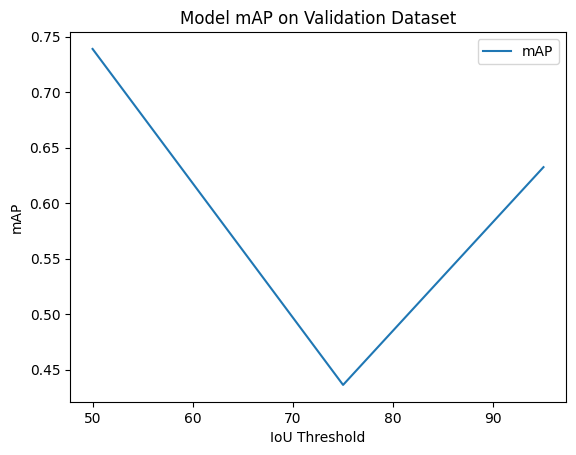

In [49]:
iou_thresholds = [50, 75, 95]  # Example IoU thresholds
map_values = [metrics.box.map50, metrics.box.map75, metrics.box.maps[-1]]  # Extract mAP values
plt.figure()
plt.plot(iou_thresholds, map_values, label='mAP')
plt.xlabel('IoU Threshold')
plt.ylabel('mAP')
plt.title('Model mAP on Validation Dataset')
plt.legend()
plt.show()

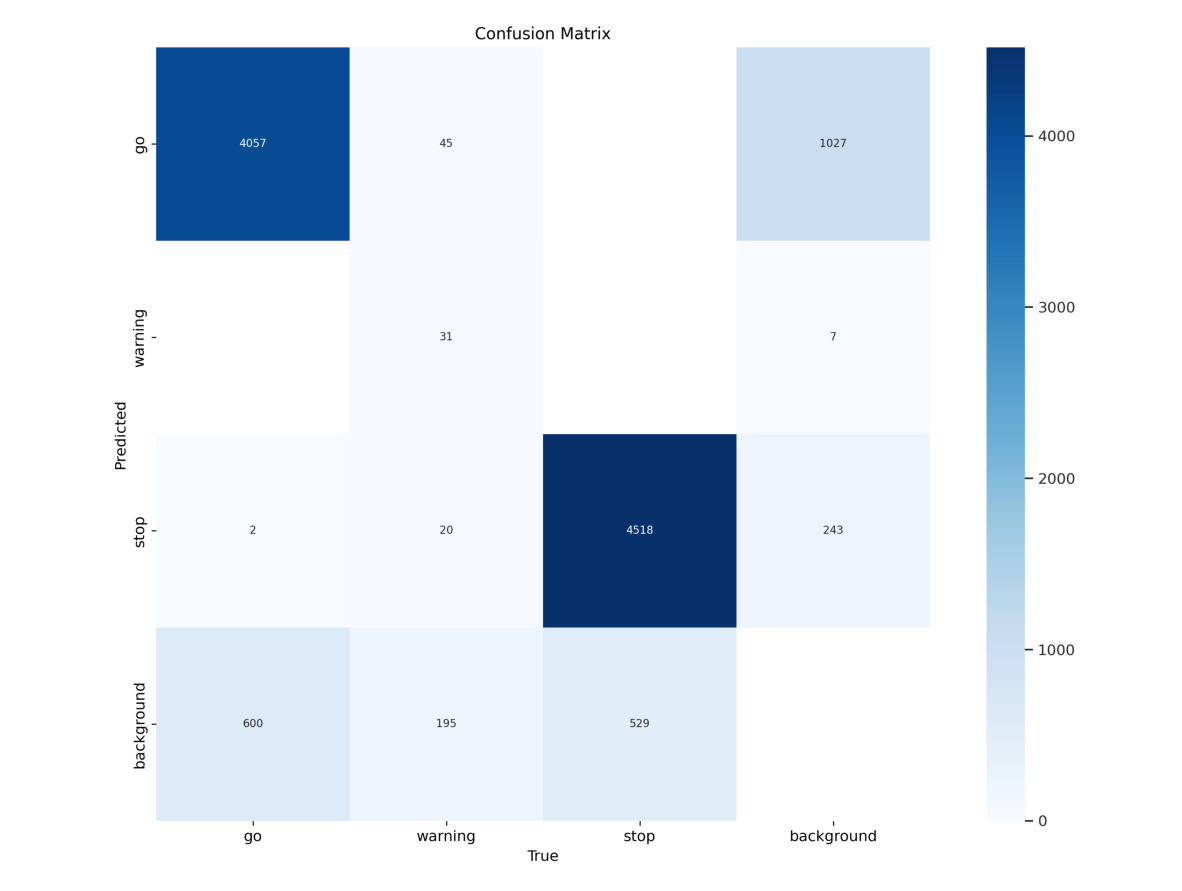

In [51]:
%matplotlib inline
# Reading the confusion matrix image file
img = cv2.imread('/content/runs/detect/train2/confusion_matrix.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


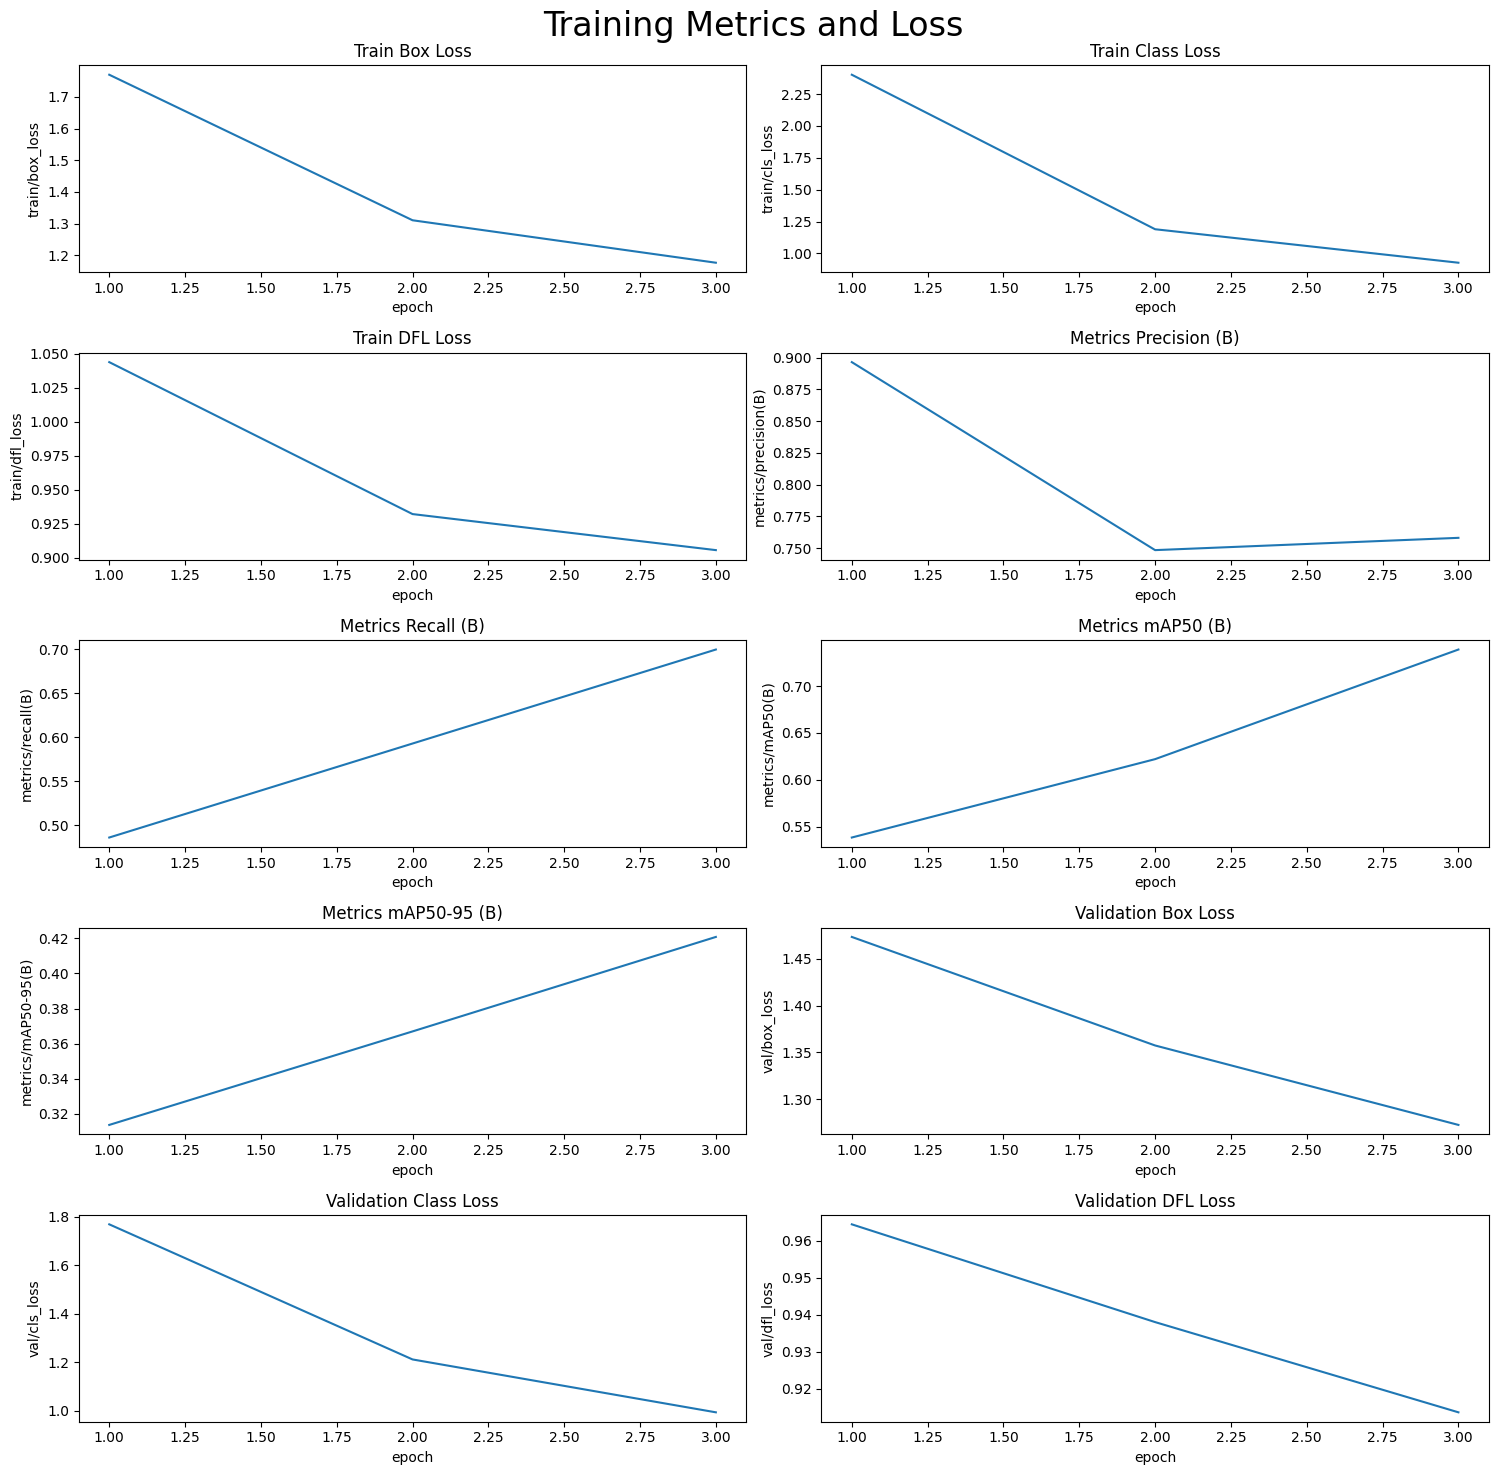

In [55]:
%matplotlib inline

import seaborn as sns
# read in the results.csv file as a pandas dataframe
result_df = pd.read_csv('/content/runs/detect/train2/results.csv')
result_df.columns = result_df.columns.str.strip()
print(result_df.columns)

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=result_df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=result_df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=result_df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=result_df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=result_df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=result_df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=result_df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=result_df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=result_df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=result_df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [8]:
# Define source as YouTube video URL
source = 'https://www.youtube.com/watch?v=JVwLv_r5dI0'
#
# https://www.youtube.com/watch?v=hMzV58Y_1wE
# https://www.youtube.com/watch?v=1gUiaLlYBJ0
# Run inference on the source
import cv2
from ultralytics import YOLO
model = YOLO("/content/yolov8n.pt")
youtube_result = model(source, save=True, show=True)  # generator of Results objects

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()




ConnectionError: 1/1: https://www.youtube.com/watch?v=JVwLv_r5dI0... Failed to read images from https://rr1---sn-qxoednee.googlevideo.com/videoplayback?expire=1708688804&ei=QzHYZbunPMmslu8P2caRWA&ip=34.135.25.254&id=o-ADabn7pES1-_GukJizfOxbsQxoYZpf8iejCnXwfCODME&itag=398&aitags=133%2C134%2C135%2C136%2C160%2C242%2C243%2C244%2C247%2C278%2C394%2C395%2C396%2C397%2C398&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&mh=G-&mm=31%2C26&mn=sn-qxoednee%2Csn-a5mlrnek&ms=au%2Conr&mv=u&mvi=1&pl=20&pcm2=no&spc=UWF9f2gBblkBqS1pFqjI5cxvhWmbtbaf4Bd_FlRvDgkxj8k&vprv=1&svpuc=1&mime=video%2Fmp4&ns=LFKfAMYVfUR0K7la1z4gIz4Q&gir=yes&clen=4112277&dur=27.899&lmt=1624304397495994&mt=1708666026&fvip=5&keepalive=yes&fexp=24007246&c=WEB&sefc=1&txp=5436432&n=wf-XYLXARGvUZj2vD&sparams=expire%2Cei%2Cip%2Cid%2Caitags%2Csource%2Crequiressl%2Cxpc%2Cpcm2%2Cspc%2Cvprv%2Csvpuc%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AJfQdSswRQIgeW1C1q127hmxyI5xMS6e5wQBuVgQ_Z4nq-vIvxdNfR0CIQDACDv_4GUKV11ZmNiTPB_fHYJ9PWClJXnDmXC6RCIWxg%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl&lsig=APTiJQcwRAIgcVCLK0QAKsDT03KnfGrGtqdmzMeJgpkjlYq5tSwM3cwCIFv3PDjWu9YCtkxC-j-wX1tD0cutHoundXqx7MhMr7Dw&ratebypass=yes

In [9]:
# Run inference on 'example clip from dataset' with arguments
model.predict('/content/drive/MyDrive/dataset/sample-dayClip6/sample-dayClip6/frames/dayClip6--00216.jpg', save=True, imgsz=320, conf=0.5)


image 1/1 /content/drive/MyDrive/dataset/sample-dayClip6/sample-dayClip6/frames/dayClip6--00216.jpg: 256x320 2 cars, 91.2ms
Speed: 1.8ms preprocess, 91.2ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)
Results saved to runs/detect/predict4


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p